# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     |████████████████████████████████| 88 kB 4.9 MB/s 
     |████████████████████████████████| 376 kB 32.7 MB/s 
     |████████████████████████████████| 58 kB 6.1 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=ad7f1e97ba00f6d73df47a380596fe5b13101ae795a827a7466b3029eb598992
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=3af180e8940ac26a4d862327546b1ff064315e878e3def802c439904c16b69ae
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-w89pf1bh
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-w89pf1bh
   

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 3.67 MiB/s, done.
Resolving deltas: 100% (3/3), done.


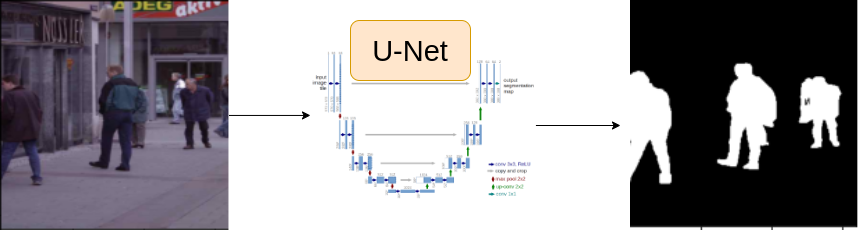

In [3]:
# El output será binario, uno o cero, donde los pixeles negros son cero
# y los pixeles blancos son uno. Igual que en la binary classification,
# el loss function puede ser binary cross entropy.

# Some Common Imports

In [4]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [5]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [6]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/conten/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [7]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [8]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)    # CV2 lee las imágenes en formato BGR por default
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    # Se convierte a formato RGB

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

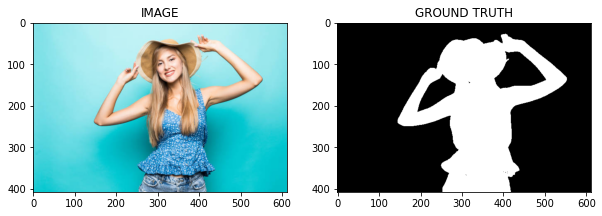

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [10]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [11]:
# Augmentation ayuda a tener variedad en el dataset.
# Hay mucho tipos de augmentation, dependiendo del dataset (object detection,
# key point, classification, segmentation).
import albumentations as A

# Para la tarea de clasificación, la augmentation se suele aplicar a las imágenes
# solo y no a los labels, porque la modificación no tiene efecto en el label.
# Para la tarea de segmentación, la augmentations se tiene que aplicar tanto
# a la imagen como al label o ground-truth, porque este último es una mask (si se
# modifica la imagen, también se modifica el gt).

In [12]:
from albumentations.augmentations.functional import is_multispectral_image

def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),  # Hay 50% de probabilidad de que la imagen se rote horizontalmente
      A.VerticalFlip(p=0.5)     # Hay 50% de probabilidad de que la imagen se rote verticalmente
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ])

# Task 4 : Create Custom Dataset 

In [13]:
# Para tener el par imagen y mask de acuerdo al index dado
from torch.utils.data import Dataset

In [14]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)    # CV2 lee las imágenes en formato BGR por default
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    # Se convierte a formato RGB
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Shape: (h, w, channel)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    # (h, w, c) -> (c, h, w)
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)
    
    # Convertir de numpy a tensor
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [15]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [16]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


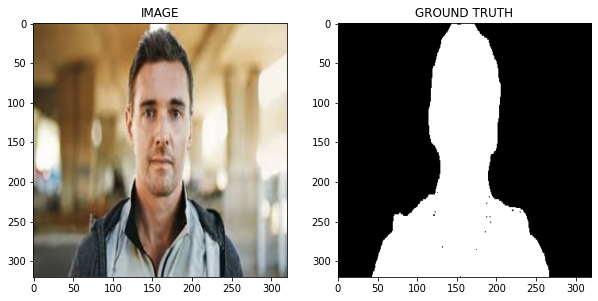

In [17]:
idx = 32
image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [18]:
from torch.utils.data import DataLoader

In [19]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [20]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [21]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [22]:
# Se usan autoencoders, en este caso el segmentation model es Unet
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [23]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,  #RGB
        classes = 1,      #Binary segmentation
        activation = None #Raw outputs without any sigmoid or softmax activation
    )

  def forward(self, images, masks=None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1+loss2

    # Cuando se hace test o inference el mask es None
    return logits

In [24]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

# Task 7 : Create Train and Validation Function 

In [26]:
def train_fn(data_loader, model, optimizer):
  # Se define que es para entrenar
  model.train()
  # La pérdida inicial es cero
  total_loss = 0.0

  # TQDM para track el número de batches
  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    # Asegurarse que los gradientes son cero
    optimizer.zero_grad()
    logits, loss = model(images, masks)
    # Se calculan los gradientes
    loss.backward()
    # Weights
    optimizer.step()

    total_loss += loss.item()

  # Se retorna la loss promedio
  return total_loss / len(data_loader)

In [27]:
def eval_fn(data_loader, model):
  model.eval()
  # La pérdida inicial es cero
  total_loss = 0.0

  # Toda esta operación no tiene que tener ningún gradient computation:
  with torch.no_grad():
    # TQDM para track el número de batches
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)
      total_loss += loss.item()

  # Se retorna la loss promedio
  return total_loss / len(data_loader)

# Task 8 : Train Model

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [29]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train loss : {train_loss} Valid loss : {valid_loss}")

100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


SAVED MODEL
Epoch : 1 Train loss : 1.0238876541455586 Valid loss : 1.365641862154007


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


SAVED MODEL
Epoch : 2 Train loss : 0.4675101737181346 Valid loss : 0.4908401742577553


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


SAVED MODEL
Epoch : 3 Train loss : 0.30235020617643993 Valid loss : 0.3328539505600929


100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Epoch : 4 Train loss : 0.2976848671833674 Valid loss : 0.41896678507328033


100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


SAVED MODEL
Epoch : 5 Train loss : 0.2745276153087616 Valid loss : 0.3084460459649563


100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Epoch : 6 Train loss : 0.207721483707428 Valid loss : 0.4607533887028694


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Epoch : 7 Train loss : 0.24994233747323355 Valid loss : 0.32925333082675934


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


SAVED MODEL
Epoch : 8 Train loss : 0.2229731301466624 Valid loss : 0.2360987327992916


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


SAVED MODEL
Epoch : 9 Train loss : 0.20327567557493845 Valid loss : 0.18126343190670013


100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


Epoch : 10 Train loss : 0.1817568525671959 Valid loss : 0.23982738330960274


100%|██████████| 4/4 [00:01<00:00,  2.38it/s]


Epoch : 11 Train loss : 0.15203666239976882 Valid loss : 0.22759924456477165


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Epoch : 12 Train loss : 0.1478772222995758 Valid loss : 0.2383757382631302


100%|██████████| 4/4 [00:01<00:00,  2.01it/s]


Epoch : 13 Train loss : 0.1586540753642718 Valid loss : 0.20129058882594109


100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


Epoch : 14 Train loss : 0.1579168438911438 Valid loss : 0.20276863873004913


100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


Epoch : 15 Train loss : 0.1336647927761078 Valid loss : 0.21620965376496315


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Epoch : 16 Train loss : 0.12277510215838751 Valid loss : 0.21938302367925644


100%|██████████| 4/4 [00:01<00:00,  2.21it/s]


Epoch : 17 Train loss : 0.11651397397120794 Valid loss : 0.1890626735985279


100%|██████████| 4/4 [00:01<00:00,  2.18it/s]


Epoch : 18 Train loss : 0.10898163318634033 Valid loss : 0.19520729780197144


100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


Epoch : 19 Train loss : 0.10960169037183126 Valid loss : 0.21287419646978378


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Epoch : 20 Train loss : 0.09660171071688334 Valid loss : 0.21538781374692917


100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


Epoch : 21 Train loss : 0.09137422541777293 Valid loss : 0.2166360430419445


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


SAVED MODEL
Epoch : 22 Train loss : 0.09884769320487977 Valid loss : 0.17152437008917332


100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


Epoch : 23 Train loss : 0.10048533280690511 Valid loss : 0.18304051086306572


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epoch : 24 Train loss : 0.0897919217745463 Valid loss : 0.26393191143870354


100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

Epoch : 25 Train loss : 0.0956585576136907 Valid loss : 0.21281703561544418


# Task 9 : Inference

In [30]:
idx = 20

# Como el dataset es muy pequeño entonces vamos a usar el validation
# set como test set (porque no tenemos otro)

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

# Se usa unsqueeze para añadir el batch dimension
logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C, H, W) -> (1, C, H, W)
# Como es un binary segmentation problem y no tiene ninguna capa de
# activación, entonces se usa sigmoide aquí
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0 # Si el pixel value es mayor a 0.5 entonces 
                                  # se declara como 1

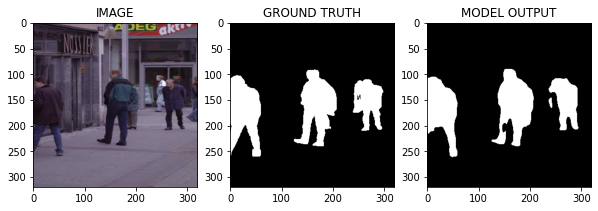

In [31]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))
# .detach().cpu() se mueve a CPU porque antes se tenía en la GPU
# .squeeze(0) para eliminar la batch dimension que se había agregado

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya